In [1]:
!pip install biopython
!pip install transformers

In [2]:
import os
import gzip
import pickle
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
from matplotlib import pyplot as plt

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [5]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
# model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial_wholegene"

model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')


# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    # softcorrect = softcorrect.item()
    softcorrect = softcorrect


    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load genes and fake ORFs
d = "drive/My Drive/Colab Notebooks/smaug/data"
gene_ORF_path = os.path.join(d, "ecoli_MG1655_geneORFs.pkl")
fake_ORF_path = os.path.join(d, "ecoli_MG1655_fakeORFs.pkl")
# gene_ORF_path = os.path.join(d, "Staphylococcus_geneORFs.pkl")
# fake_ORF_path = os.path.join(d, "Staphylococcus_fakeORFs.pkl")

with open(gene_ORF_path, 'rb') as f:
    gene_aa_filtered = pickle.load(f)
with open(fake_ORF_path, 'rb') as f:
    fake_aa = pickle.load(f)

gene_aa_filtered = [x for x in gene_aa_filtered if len(x) > 40]
fake_aa = [x for x in fake_aa if len(x) > 40]

In [0]:
gene_aa_flat = np.zeros([len(gene_aa_filtered), 1024], dtype=int)
for i, ORFseq in enumerate(gene_aa_filtered):
    ORFtokens = np.array(tokenize_aa_seq(ORFseq))
    gene_aa_flat[i, :len(ORFtokens)] += ORFtokens[:1024]

fake_aa_flat = np.zeros([len(fake_aa), 1024], dtype=int)
for i, ORFseq in enumerate(fake_aa):
    ORFtokens = np.array(tokenize_aa_seq(ORFseq))
    fake_aa_flat[i, :len(ORFtokens)] += ORFtokens[:1024]

gene_aa_flat = torch.tensor(gene_aa_flat)
fake_aa_flat = torch.tensor(fake_aa_flat)

In [40]:
# use GPU model to score ORFs, corrected for non-buffered length
BATCH_SIZE = 2**2 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(gene_aa_flat), BATCH_SIZE):
    print(i, "of", len(gene_aa_flat))

    input_ids = gene_aa_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect_probability = []
        length = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            correct_val = input_ids[i,j+1]
            if correct_val.item() != 0:
                softcorrect_probability.append(softproportion[i, j, correct_val.item()].item())
        scorelogs = np.log(softcorrect_probability)
        score = np.exp(np.mean(scorelogs)) # take average in log space

        softcorrect_list.append(score)

    softcorrect_all.extend(softcorrect_list)

0 of 3436
4 of 3436
8 of 3436
12 of 3436
16 of 3436
20 of 3436
24 of 3436
28 of 3436
32 of 3436
36 of 3436
40 of 3436
44 of 3436
48 of 3436
52 of 3436
56 of 3436
60 of 3436
64 of 3436
68 of 3436
72 of 3436
76 of 3436
80 of 3436
84 of 3436
88 of 3436
92 of 3436
96 of 3436
100 of 3436
104 of 3436
108 of 3436
112 of 3436
116 of 3436
120 of 3436
124 of 3436
128 of 3436
132 of 3436
136 of 3436
140 of 3436
144 of 3436
148 of 3436
152 of 3436
156 of 3436
160 of 3436
164 of 3436
168 of 3436
172 of 3436
176 of 3436
180 of 3436
184 of 3436
188 of 3436
192 of 3436
196 of 3436
200 of 3436
204 of 3436
208 of 3436
212 of 3436
216 of 3436
220 of 3436
224 of 3436
228 of 3436
232 of 3436
236 of 3436
240 of 3436
244 of 3436
248 of 3436
252 of 3436
256 of 3436
260 of 3436
264 of 3436
268 of 3436
272 of 3436
276 of 3436
280 of 3436
284 of 3436
288 of 3436
292 of 3436
296 of 3436
300 of 3436
304 of 3436
308 of 3436
312 of 3436
316 of 3436
320 of 3436
324 of 3436
328 of 3436
332 of 3436
336 of 3436
340 of 3

In [41]:
# use GPU model to score ARFs, corrected for non-buffered length
BATCH_SIZE = 2**2 # limited by vram

softcorrect_all_arf = []

for i in range(0, len(fake_aa_flat), BATCH_SIZE):
    print(i, "of", len(fake_aa_flat))

    input_ids = fake_aa_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect_probability = []
        length = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            correct_val = input_ids[i,j+1]
            if correct_val.item() != 0:
                softcorrect_probability.append(softproportion[i, j, correct_val.item()].item())
        scorelogs = np.log(softcorrect_probability)
        score = np.exp(np.mean(scorelogs)) # take average in log space

        softcorrect_list.append(score)

    softcorrect_all_arf.extend(softcorrect_list)

0 of 29427
4 of 29427
8 of 29427
12 of 29427
16 of 29427
20 of 29427
24 of 29427
28 of 29427
32 of 29427
36 of 29427
40 of 29427
44 of 29427
48 of 29427
52 of 29427
56 of 29427
60 of 29427
64 of 29427
68 of 29427
72 of 29427
76 of 29427
80 of 29427
84 of 29427
88 of 29427
92 of 29427
96 of 29427
100 of 29427
104 of 29427
108 of 29427
112 of 29427
116 of 29427
120 of 29427
124 of 29427
128 of 29427
132 of 29427
136 of 29427
140 of 29427
144 of 29427
148 of 29427
152 of 29427
156 of 29427
160 of 29427
164 of 29427
168 of 29427
172 of 29427
176 of 29427
180 of 29427
184 of 29427
188 of 29427
192 of 29427
196 of 29427
200 of 29427
204 of 29427
208 of 29427
212 of 29427
216 of 29427
220 of 29427
224 of 29427
228 of 29427
232 of 29427
236 of 29427
240 of 29427
244 of 29427
248 of 29427
252 of 29427
256 of 29427
260 of 29427
264 of 29427
268 of 29427
272 of 29427
276 of 29427
280 of 29427
284 of 29427
288 of 29427
292 of 29427
296 of 29427
300 of 29427
304 of 29427
308 of 29427
312 of 29427
3

In [20]:
# use GPU model to score ORFs
BATCH_SIZE = 2**0 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(gene_aa_flat), BATCH_SIZE):
    print(i, "of", len(gene_aa_flat))

    input_ids = gene_aa_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all.extend(softcorrect_list)
    hardcorrect_all.extend(hardcorrect_list)

0 of 3436
1 of 3436
2 of 3436
3 of 3436
4 of 3436
5 of 3436
6 of 3436
7 of 3436
8 of 3436
9 of 3436
10 of 3436
11 of 3436
12 of 3436
13 of 3436
14 of 3436
15 of 3436
16 of 3436
17 of 3436
18 of 3436
19 of 3436
20 of 3436
21 of 3436
22 of 3436
23 of 3436
24 of 3436
25 of 3436
26 of 3436
27 of 3436
28 of 3436
29 of 3436
30 of 3436
31 of 3436
32 of 3436
33 of 3436
34 of 3436
35 of 3436
36 of 3436
37 of 3436
38 of 3436
39 of 3436
40 of 3436
41 of 3436
42 of 3436
43 of 3436
44 of 3436
45 of 3436
46 of 3436
47 of 3436
48 of 3436
49 of 3436
50 of 3436
51 of 3436
52 of 3436
53 of 3436
54 of 3436
55 of 3436
56 of 3436
57 of 3436
58 of 3436
59 of 3436
60 of 3436
61 of 3436
62 of 3436
63 of 3436
64 of 3436
65 of 3436
66 of 3436
67 of 3436
68 of 3436
69 of 3436
70 of 3436
71 of 3436
72 of 3436
73 of 3436
74 of 3436
75 of 3436
76 of 3436
77 of 3436
78 of 3436
79 of 3436
80 of 3436
81 of 3436
82 of 3436
83 of 3436
84 of 3436
85 of 3436
86 of 3436
87 of 3436
88 of 3436
89 of 3436
90 of 3436
91 of 343

KeyboardInterrupt: ignored

In [0]:
# use GPU model to score fake ORFs
BATCH_SIZE = 2**0 # limited by vram

softcorrect_all_arf = []
hardcorrect_all_arf = []

for i in range(0, len(fake_aa_flat), BATCH_SIZE):
    print(i, "of", len(fake_aa_flat))

    input_ids = fake_aa_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all_arf.extend(softcorrect_list)
    hardcorrect_all_arf.extend(hardcorrect_list)

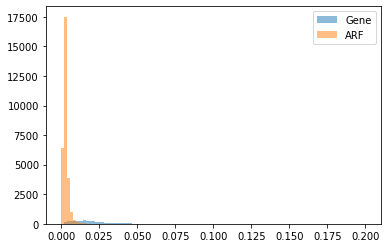

In [0]:
bins = np.linspace(0, 0.2, 100)
plt.hist(softcorrect_all, bins, alpha=0.5, label="Gene")
plt.hist(softcorrect_all_arf, bins, alpha=0.5, label="ARF")
plt.legend(loc='upper right')
plt.show()

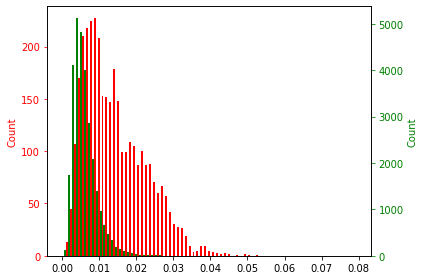

In [43]:
#https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#sets up the axis and gets histogram data
colors = ["red", "green"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([softcorrect_all, softcorrect_all_arf], color=colors)
n, bins, patches = ax1.hist([softcorrect_all,softcorrect_all_arf], bins=75, range=[0.00,0.08])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * .5
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

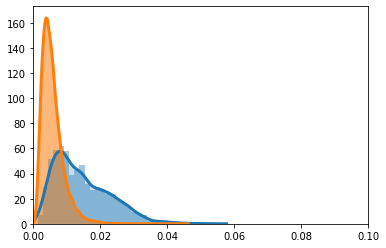

In [44]:
import seaborn as sns
sns.distplot(softcorrect_all, hist = True, kde = True, norm_hist= True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'gene')
sns.distplot(softcorrect_all_arf, hist = True, kde = True, norm_hist= True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'ARF')
plt.xlim([0.00,0.10])

plt.show()